This project analyzes my workout history to understand training trends and estimate future strength progress. Using exported workout logs, I clean and structure the dataset into exercise- and time-based summaries that make it possible to compare intensity and volume across days and weeks.

A major part of the analysis is separating sessions into low vs high volume days (based on sets and rep ranges) to evaluate how volume impacts performance. I compute core training metrics such as daily max weight, weekly max weight, total reps, and estimated training volume (weight × reps), then visualize these patterns over time. I also calculate correlations between volume and performance, including lag correlations to test whether higher workload in one week relates to improved strength in later weeks.

For forecasting, I implement baseline linear regression predictions on weekly max weight and create an estimated 1RM (e1RM) modeling pipeline using lag features (previous e1RM values + rolling averages and volume history). Future e1RM values are predicted iteratively week-by-week to generate a multi-week strength projection for key lifts. This provides a simple but structured way to track progress and turn training history into actionable insights.

In [24]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sqlite3



In [25]:
# create a data frame from the workout csv
df = pd.read_csv('workout_data.csv')
df.head()

,title,start_time,end_time,description,exercise_title,superset_id,exercise_notes,set_index,set_type,weight_lbs,reps,distance_miles,duration_seconds,rpe
0,Morning workout ☀️,"13 Jan 2026, 06:53","13 Jan 2026, 08:15",NaN,Clean,NaN,NaN,0,normal,195.0,3,NaN,NaN,NaN
1,Morning workout ☀️,"13 Jan 2026, 06:53","13 Jan 2026, 08:15",NaN,Clean,NaN,NaN,1,normal,195.0,3,NaN,NaN,NaN
2,Morning workout ☀️,"13 Jan 2026, 06:53","13 Jan 2026, 08:15",NaN,Clean,NaN,NaN,2,normal,195.0,3,NaN,NaN,NaN
3,Morning workout ☀️,"13 Jan 2026, 06:53","13 Jan 2026, 08:15",NaN,Clean,NaN,NaN,3,normal,195.0,3,NaN,NaN,NaN
4,Morning workout ☀️,"13 Jan 2026, 06:53","13 Jan 2026, 08:15",NaN,Front Squat,NaN,NaN,0,normal,225.0,3,NaN,NaN,NaN


In [26]:
# get the columns names to be used later
df.columns

# want exercise_title, start_time, end_time, weight_lbs, reps, set_index, set_type 

Index(['title', 'start_time', 'end_time', 'description', 'exercise_title',
       'superset_id', 'exercise_notes', 'set_index', 'set_type', 'weight_lbs',
       'reps', 'distance_miles', 'duration_seconds', 'rpe'],
      dtype='object')

I isolate only the columns needed for training trend analysis (exercise title, timestamps, weight, reps, set index/type).

In [27]:
# create a new data frame with only the relevant columns
table = df[[
  'exercise_title',
  'start_time',
  'end_time',
  'weight_lbs',
  'reps',
  'set_index',
  'set_type'
]]

# display the first few rows of the new table
print(table.head())

  exercise_title          start_time            end_time  weight_lbs  reps  \
0          Clean  13 Jan 2026, 06:53  13 Jan 2026, 08:15       195.0     3   
1          Clean  13 Jan 2026, 06:53  13 Jan 2026, 08:15       195.0     3   
2          Clean  13 Jan 2026, 06:53  13 Jan 2026, 08:15       195.0     3   
3          Clean  13 Jan 2026, 06:53  13 Jan 2026, 08:15       195.0     3   
4    Front Squat  13 Jan 2026, 06:53  13 Jan 2026, 08:15       225.0     3   

   set_index set_type  
0          0   normal  
1          1   normal  
2          2   normal  
3          3   normal  
4          0   normal  


I convert start and end time columns to datetime format and extract a day column to group workouts by date. Workout-level comparisons are easier when grouped by day instead of raw timestamps. This makes it possible to do “daily max weight” tracking and volume labeling consistently.

In [28]:
# I want to sort the data based on the number of sets performed for each exercise and the date 

# change the date format -> datetime
table["start_time"] = pd.to_datetime(table["start_time"])
table["end_time"]   = pd.to_datetime(table["end_time"])

table["day"] = table["start_time"].dt.date   # just the date (YYYY-MM-DD)

# view the change 
print(table.head())

  exercise_title          start_time            end_time  weight_lbs  reps  \
0          Clean 2026-01-13 06:53:00 2026-01-13 08:15:00       195.0     3   
1          Clean 2026-01-13 06:53:00 2026-01-13 08:15:00       195.0     3   
2          Clean 2026-01-13 06:53:00 2026-01-13 08:15:00       195.0     3   
3          Clean 2026-01-13 06:53:00 2026-01-13 08:15:00       195.0     3   
4    Front Squat 2026-01-13 06:53:00 2026-01-13 08:15:00       225.0     3   

   set_index set_type         day  
0          0   normal  2026-01-13  
1          1   normal  2026-01-13  
2          2   normal  2026-01-13  
3          3   normal  2026-01-13  
4          0   normal  2026-01-13  


/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/3157634754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["start_time"] = pd.to_datetime(table["start_time"])
/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/3157634754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["end_time"]   = pd.to_datetime(table["end_time"])
/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/3157634754.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

I group by day and exercise_title and count rows to estimate how many sets were performed for each exercise per day. This creates a simple proxy for volume (set count) that can be used to compare low vs high volume sessions. Set count is a useful first approximation, but doesn’t capture rep-based differences (ex: 2x10 vs 2x3).

In [29]:
# group by day and exercise title to count the number of sets performed each day for each exercise
sets_per_day = (
    table.groupby(["day", "exercise_title"])
         .size()
         .reset_index(name="num_sets")
)

# display the result
print(sets_per_day)

             day            exercise_title  num_sets
0     2024-03-01        Deadlift (Barbell)        10
1     2024-03-01      Lat Pulldown (Cable)         4
2     2024-03-01  Preacher Curl (Dumbbell)         4
3     2024-03-01                   Pull Up         2
4     2024-03-01         Smith Machine Row         4
...          ...                       ...       ...
3366  2026-01-13                     Clean         4
3367  2026-01-13               Front Squat         4
3368  2026-01-13     Single Leg Extensions         2
3369  2026-01-13        Standing Leg Curls         2
3370  2026-01-13             Zercher Squat         2

[3371 rows x 3 columns]


I define a threshold (≤2 sets = low volume, >2 sets = high volume) and split exercise-days into separate datasets. I wanted to test whether heavier weights tend to occur on days with fewer sets, and if volume affects intensity trends. This definition is simple, but can misclassify high-rep workouts (low sets but very high reps).

In [30]:
# now that the data is grouped, I want to separate the data based on set number i.e lower volume vs higher volume per exercise
# define a threshold for high volume vs low volume

threshold = 2  # more than 3 sets is high volume 

# define low volume and high volume data frames
low_volume = sets_per_day[sets_per_day["num_sets"] <= threshold] # less than or equal to threshold -> low volume
high_volume = sets_per_day[sets_per_day["num_sets"] > threshold] # greater than threshold -> high volume

# display the low volume and high volume data frames
print("Low Volume Sets (2 or less sets):")
print(low_volume)

print("High Volume Sets (3 or more sets):")
print(high_volume)

Low Volume Sets (2 or less sets):
             day                       exercise_title  num_sets
3     2024-03-01                              Pull Up         2
9     2024-03-04               Hammer Curl (Dumbbell)         2
17    2024-03-05  Single Arm Triceps Pushdown (Cable)         2
35    2024-03-10                  Seated Hammer Curls         2
43    2024-03-11               Sissy Squat (Weighted)         1
...          ...                                  ...       ...
3364  2026-01-12     Seated Cable Row - Bar Wide Grip         2
3365  2026-01-12            Shoulder Press (Dumbbell)         2
3368  2026-01-13                Single Leg Extensions         2
3369  2026-01-13                   Standing Leg Curls         2
3370  2026-01-13                        Zercher Squat         2

[1357 rows x 3 columns]
High Volume Sets (3 or more sets):
             day                     exercise_title  num_sets
0     2024-03-01                 Deadlift (Barbell)        10
1     2024-03-

In [31]:
# compare the weight used in low volume vs high volume sets over time 
# want to see if there is a trend in the weight used based on volume 
  # is there a significant difference in weight used between low and high volume sets?
  # am i making more progress with lower volume sets?

# merge the original table with the low and high volume data frames to get the weight used for each set
low_volume_data = pd.merge(table, low_volume, on=["day", "exercise_title"])
high_volume_data = pd.merge(table, high_volume, on=["day", "exercise_title"])

# display the merged data frames
print("Low Volume Data:")
print(low_volume_data)
print("High Volume Data:")
print(high_volume_data)

Low Volume Data:
                           exercise_title          start_time  \
0                           Zercher Squat 2026-01-13 06:53:00   
1                           Zercher Squat 2026-01-13 06:53:00   
2                   Single Leg Extensions 2026-01-13 06:53:00   
3                   Single Leg Extensions 2026-01-13 06:53:00   
4                      Standing Leg Curls 2026-01-13 06:53:00   
...                                   ...                 ...   
2587  Single Arm Triceps Pushdown (Cable) 2024-03-05 12:17:00   
2588               Hammer Curl (Dumbbell) 2024-03-04 12:45:00   
2589               Hammer Curl (Dumbbell) 2024-03-04 12:45:00   
2590                              Pull Up 2024-03-01 15:00:00   
2591                              Pull Up 2024-03-01 15:00:00   

                end_time  weight_lbs  reps  set_index set_type         day  \
0    2026-01-13 08:15:00       235.0     4          0   normal  2026-01-13   
1    2026-01-13 08:15:00       235.0     5    

I plot weight over time, labeling each set as low volume or high volume based on the day classification. This provides a quick visual comparison of intensity distribution across different volume days. This plot becomes cluttered quickly because it shows every set. It’s better for identifying general patterns than clean trends.

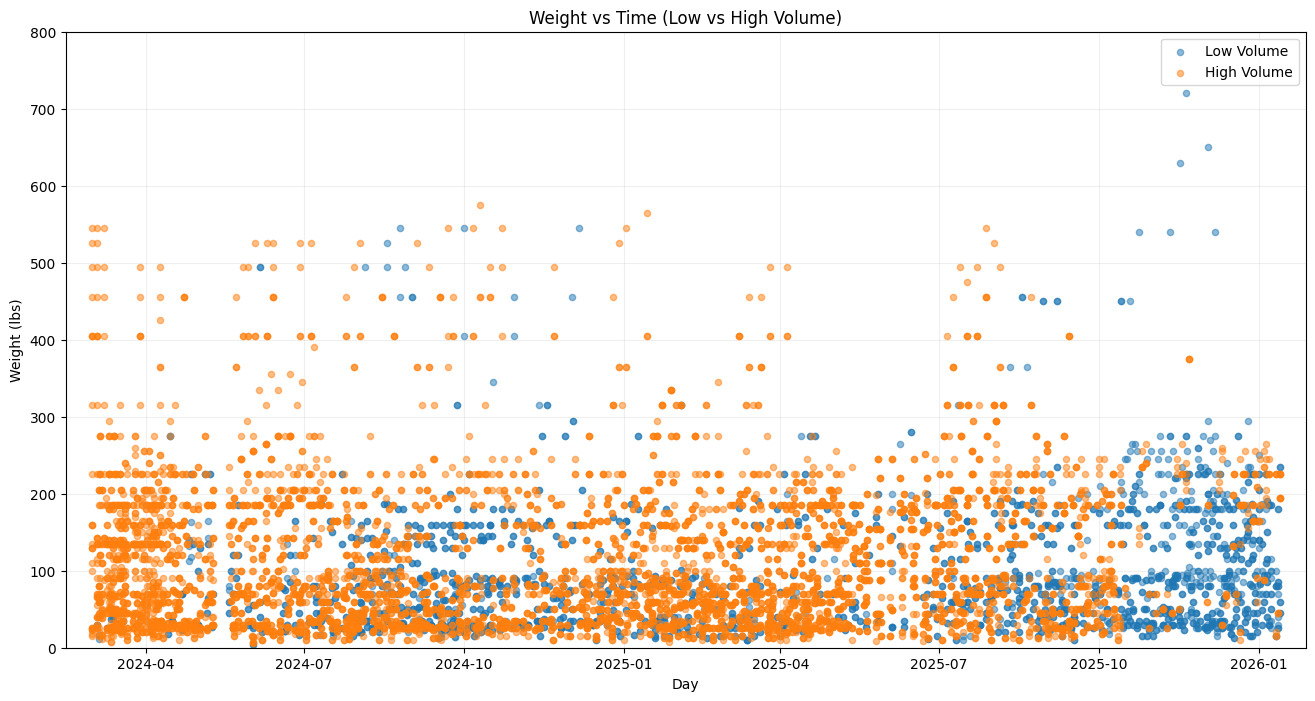

In [32]:
# visualize the weight used in low volume vs high volume sets over time
plt.figure(figsize=(16, 8))

# plot low volume data
plt.scatter(low_volume_data["day"], low_volume_data["weight_lbs"], label="Low Volume", alpha=0.5, s=20)

# plot high volume data
plt.scatter(high_volume_data["day"], high_volume_data["weight_lbs"], label="High Volume", alpha=0.5, s=20)

# set y limit for better visualization
plt.ylim(0, 800)

# set x limit for better visualization
plt.xlim(table["day"].min() - pd.Timedelta(days=15), table["day"].max() + pd.Timedelta(days=15))

# add labels and title
plt.xlabel("Day")
plt.ylabel("Weight (lbs)")
plt.title("Weight vs Time (Low vs High Volume)")
plt.legend()
plt.grid(True, alpha=0.2)

# show the plot
plt.show()


this plot isn't very clear, so I want to create a line plot of specific exercises to see if there is a trend in weight used over time based on volume. This plot only shows volume based on set number not the number of reps. 

In [33]:
# creating a function to plot weight vs time for a specific exercise and volume 

# filter for specific exercises
exercises = ["Front Squat", "Clean", "Squat (Barbell)", "Bench Press (Barbell)", "Shoulder Press (Dumbbell)", "Lat Pulldown (Cable)"]   

# filter the table for the specific exercises
df_ex = table[table["exercise_title"].isin(exercises)].copy()

# display the filtered data frame
df_ex.head()

,exercise_title,start_time,end_time,weight_lbs,reps,set_index,set_type,day
0,Clean,2026-01-13 06:53:00,2026-01-13 08:15:00,195.0,3,0,normal,2026-01-13
1,Clean,2026-01-13 06:53:00,2026-01-13 08:15:00,195.0,3,1,normal,2026-01-13
2,Clean,2026-01-13 06:53:00,2026-01-13 08:15:00,195.0,3,2,normal,2026-01-13
3,Clean,2026-01-13 06:53:00,2026-01-13 08:15:00,195.0,3,3,normal,2026-01-13
4,Front Squat,2026-01-13 06:53:00,2026-01-13 08:15:00,225.0,3,0,normal,2026-01-13


For specific exercises, I compute the daily maximum weight separately for low vs high volume days and plot it over time. Daily max weight provides a cleaner trendline and helps reveal whether heavy days cluster in low volume sessions. This shows “strength expression” more clearly than plotting raw sets, but still depends heavily on the volume definition.

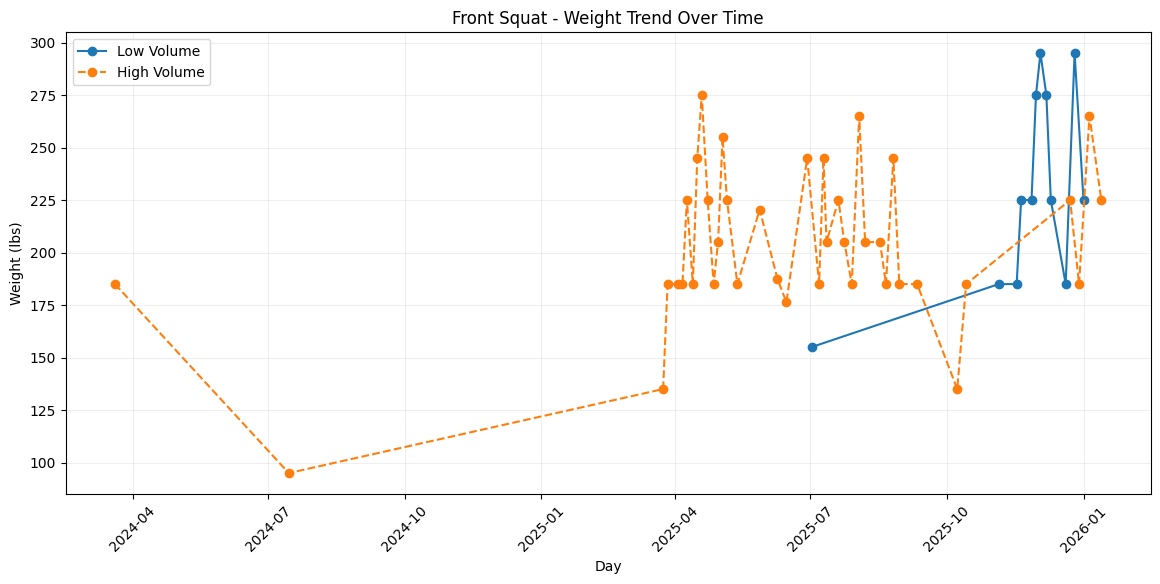

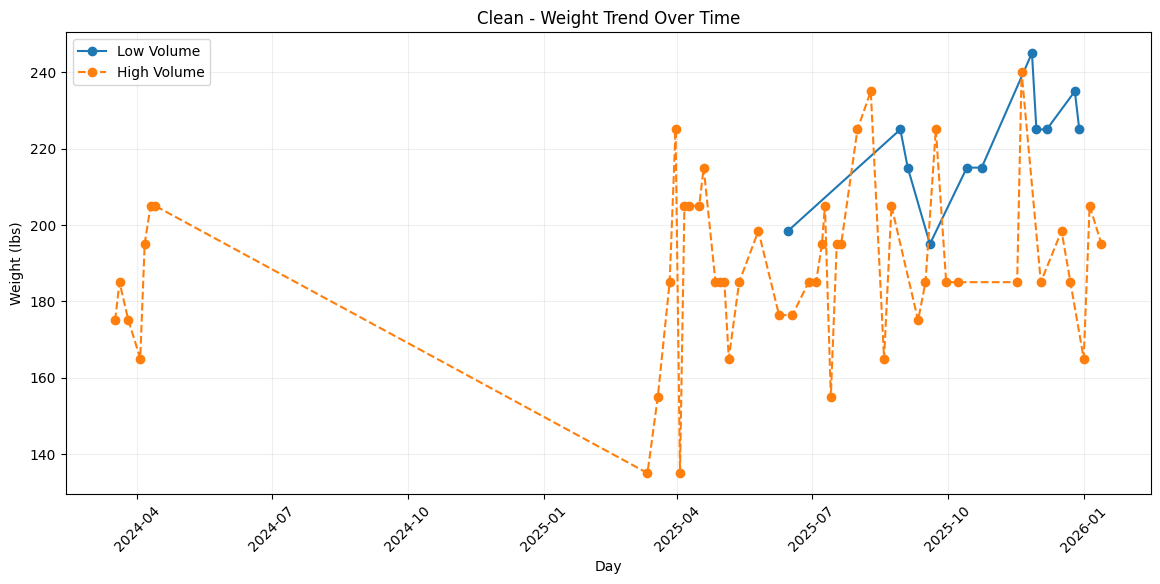

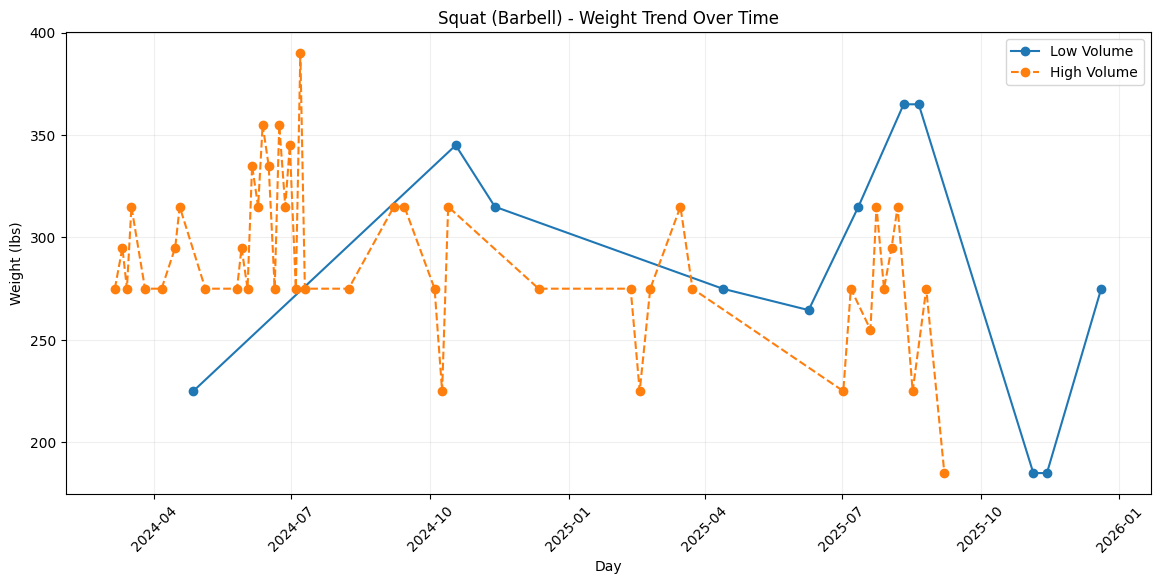

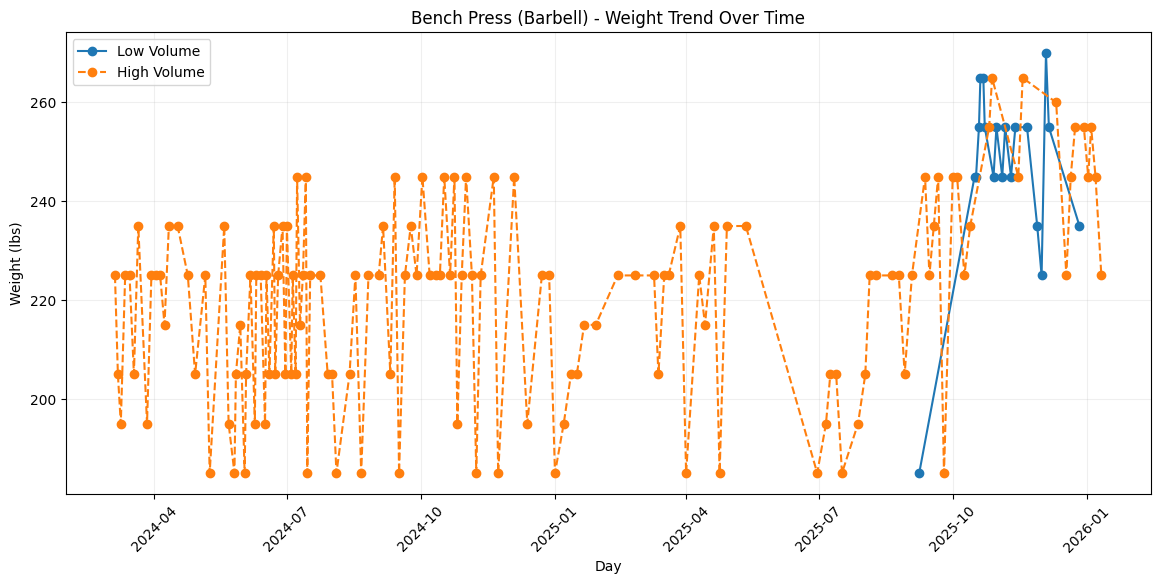

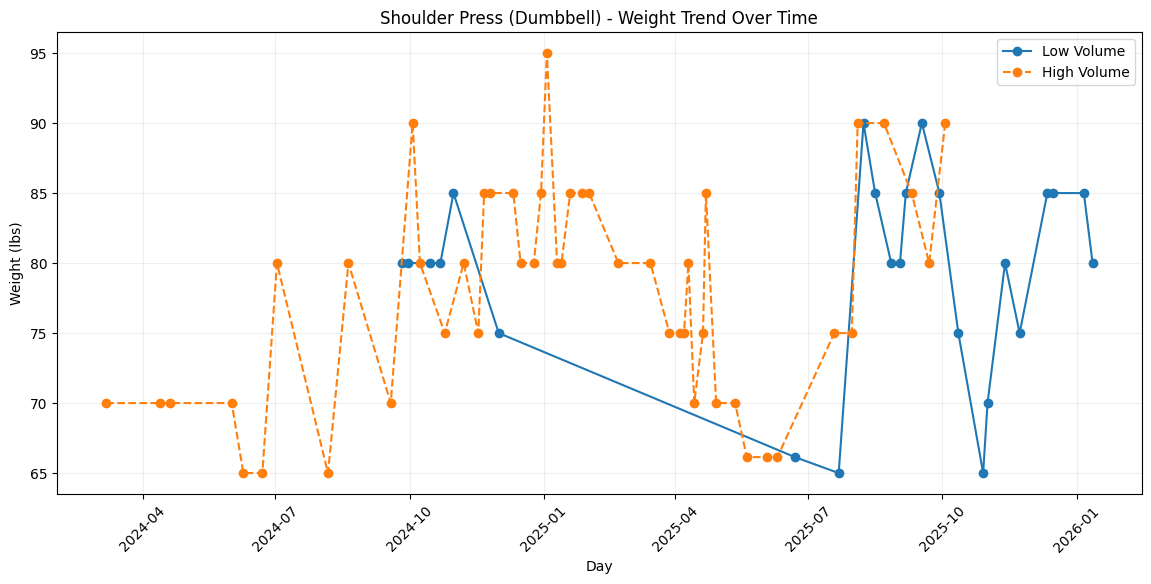

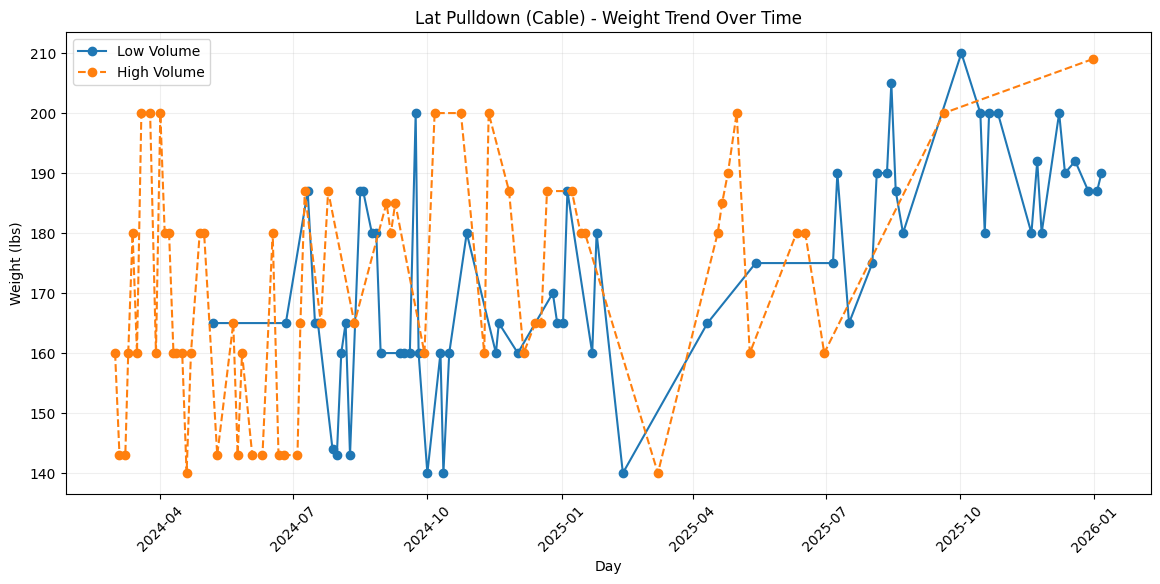

In [34]:
# make sure day is datetime
low_volume_data["day"]  = pd.to_datetime(low_volume_data["day"])
high_volume_data["day"] = pd.to_datetime(high_volume_data["day"])

for ex in exercises:
    # filter each exercise
    low_ex  = low_volume_data[low_volume_data["exercise_title"] == ex]
    high_ex = high_volume_data[high_volume_data["exercise_title"] == ex]

    # aggregate daily max weight to graph 
    low_trend = low_ex.groupby("day")["weight_lbs"].max()
    high_trend = high_ex.groupby("day")["weight_lbs"].max()

    # plot
    plt.figure(figsize=(14, 6))

    plt.plot(low_trend.index, low_trend.values, marker="o", label="Low Volume")
    plt.plot(high_trend.index, high_trend.values, marker="o", linestyle="--", label="High Volume")

    plt.title(f"{ex} - Weight Trend Over Time")
    plt.xlabel("Day")
    plt.ylabel("Weight (lbs)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.xticks(rotation=45)

    plt.show()

Each graph tracks the daily max weight for a given exercise over time, separated into low-volume vs high-volume sets, to compare how intensity changes and whether heavier weights occur more in low or high volume training. The way I'm defining volume is not accurate because I'm only considering the total number of sets for the given exercise and not the reps per set. 

For the next plots, I'm redefining low volume as 2 or less sets of 1-6 reps. High volume will be 3 or more sets and 6 or more sets. This is more clear however there might be less data to work with. By adding the reps I get rid of mis-classifying exercises I do 2 or less sets and 10 or more reps as low volume. This classification is more meaningful but may reduce sample size for some lifts (fewer qualifying days). Using the new volume definition I replot the graphs.

/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/485731979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["day"] = pd.to_datetime(table["day"])


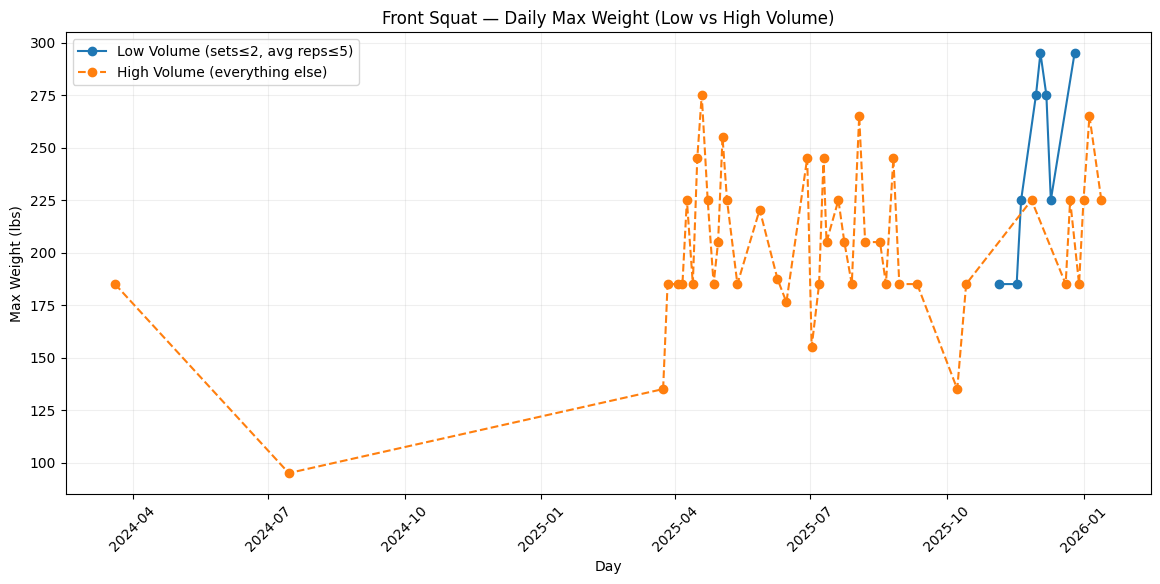

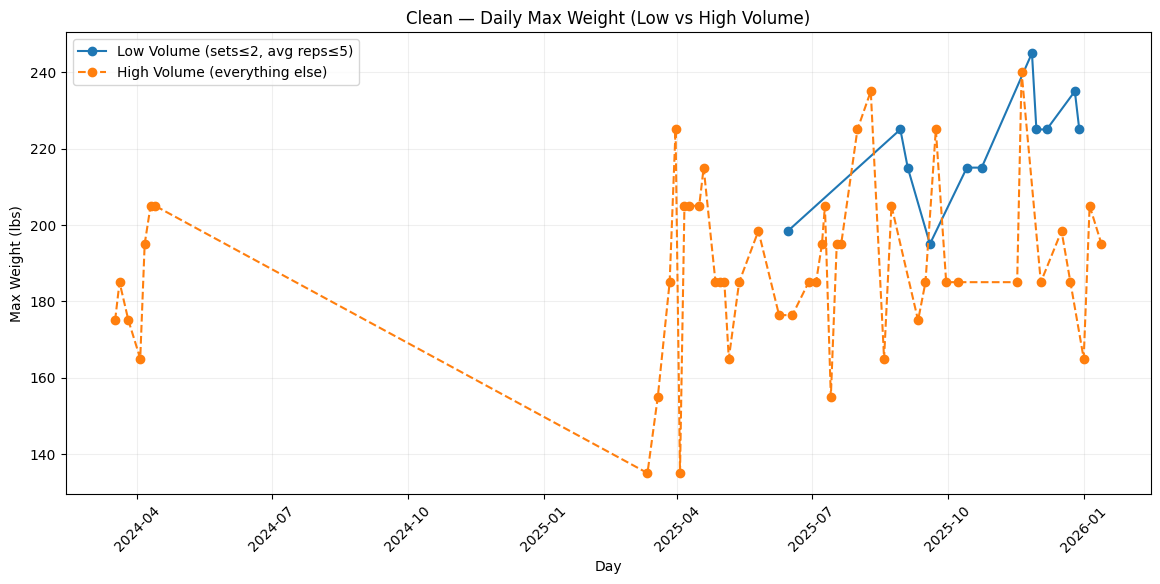

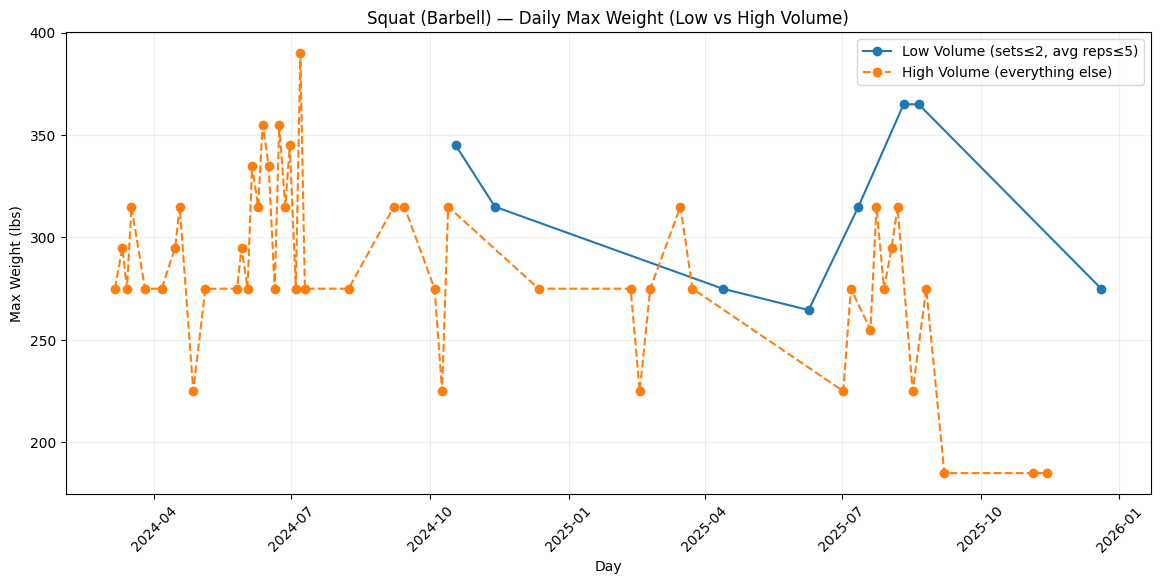

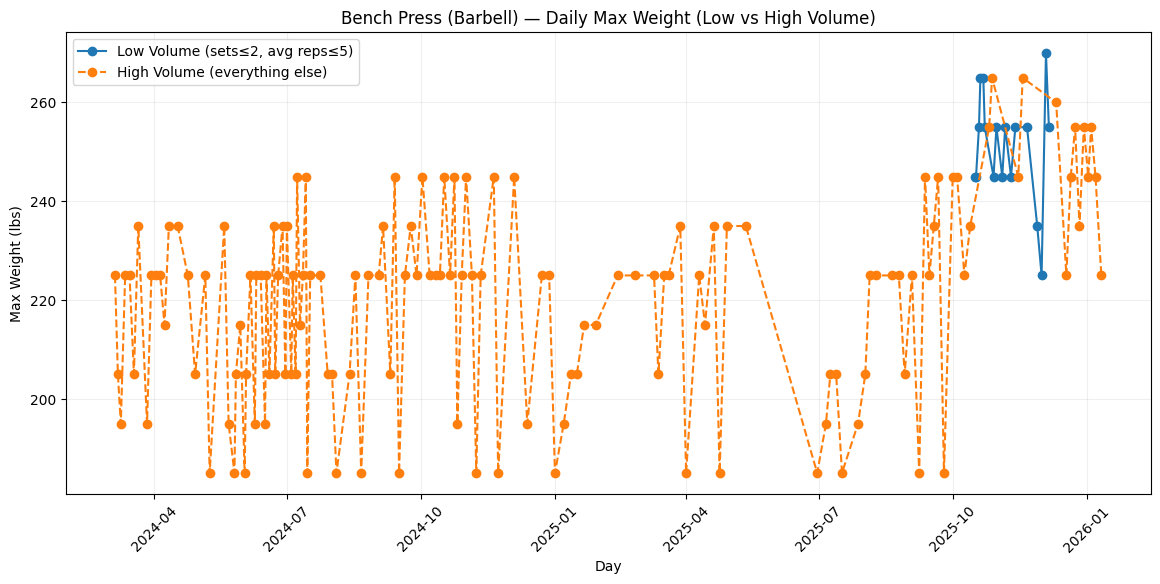

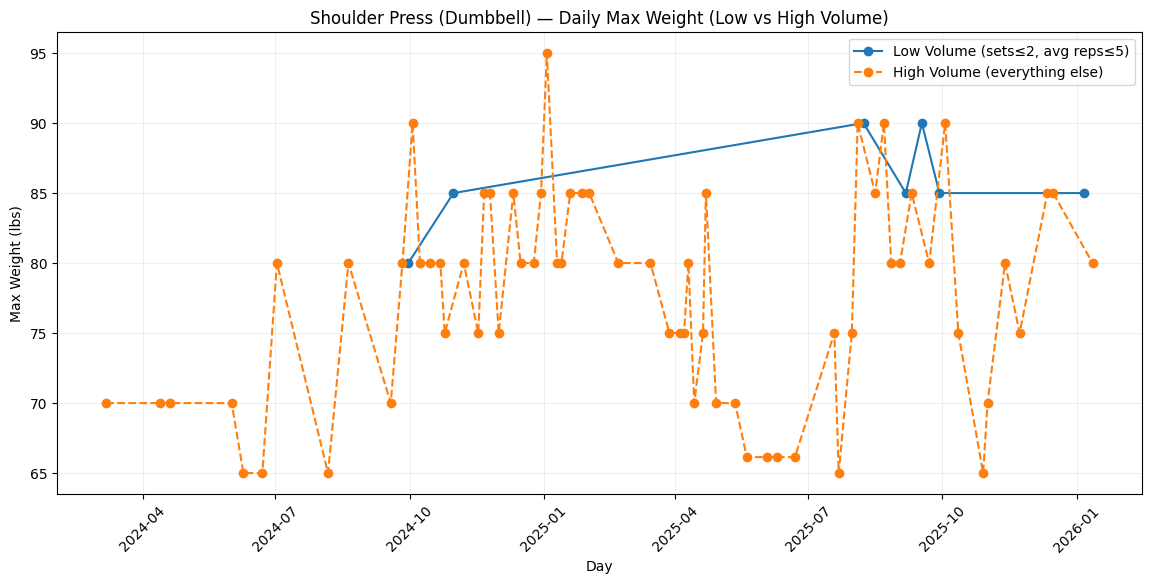

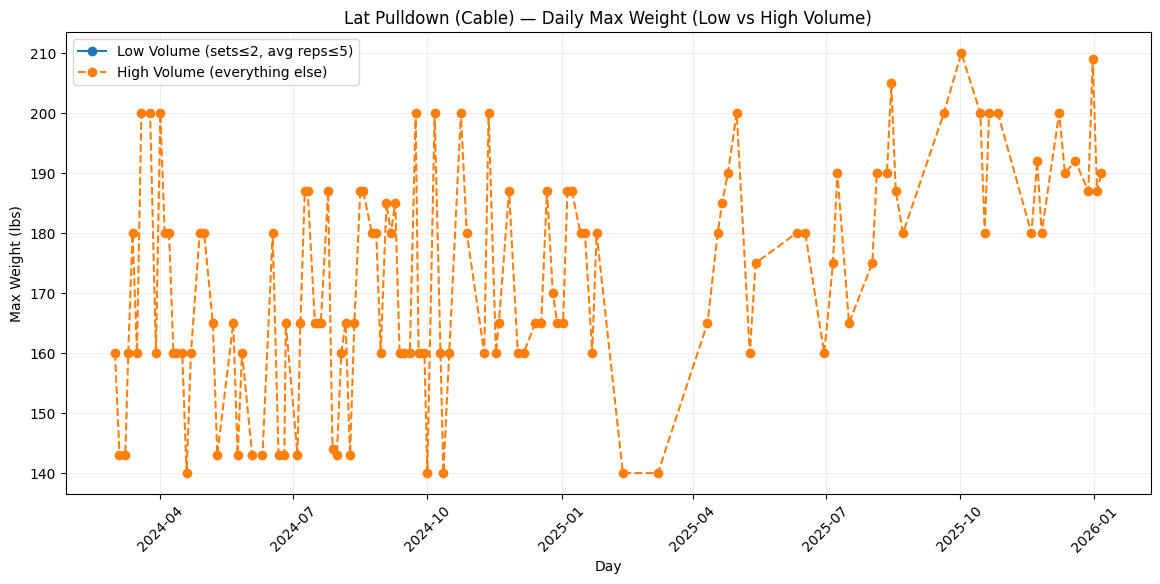

In [35]:
# Alternative approach: Label each day/exercise as low or high volume based on sets and average reps
table["day"] = pd.to_datetime(table["day"])

exercises = ["Front Squat", "Clean", "Squat (Barbell)", "Bench Press (Barbell)", "Shoulder Press (Dumbbell)", "Lat Pulldown (Cable)"]

# Daily summary per exercise with average reps 
daily_flags = (
    table[table["exercise_title"].isin(exercises)]
    .groupby(["day", "exercise_title"])
    .agg(
        total_sets=("set_index", "count"),
        avg_reps=("reps", "mean"),
        max_reps=("reps", "max")   # optional
    )
    .reset_index()
)

#  Define low volume using averages 
SET_THRESH = 2
AVG_REP_THRESH = 5

# label volume type as low or high
daily_flags["volume_type"] = "high"
daily_flags.loc[
    (daily_flags["total_sets"] <= SET_THRESH) &
    (daily_flags["avg_reps"] <= AVG_REP_THRESH),
    "volume_type"
] = "low"

# Merge labels back onto original set-level table
labeled = table.merge(
    daily_flags[["day", "exercise_title", "volume_type"]],
    on=["day", "exercise_title"],
    how="inner"
)

# Calculate daily max weight per exercise and volume type
daily_max = (
    labeled.groupby(["day", "exercise_title", "volume_type"])["weight_lbs"]
           .max()
           .reset_index()
)

# plot daily max weight for low vs high volume per exercise
for ex in exercises:
    d = daily_max[daily_max["exercise_title"] == ex].sort_values("day")
    if d.empty:
        continue

    low = d[d["volume_type"] == "low"]
    high = d[d["volume_type"] == "high"]

    plt.figure(figsize=(14, 6))
    plt.plot(low["day"], low["weight_lbs"], marker="o", label=f"Low Volume (sets≤{SET_THRESH}, avg reps≤{AVG_REP_THRESH})")
    plt.plot(high["day"], high["weight_lbs"], marker="o", linestyle="--", label="High Volume (everything else)")

    plt.title(f"{ex} — Daily Max Weight (Low vs High Volume)")
    plt.xlabel("Day")
    plt.ylabel("Max Weight (lbs)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.xticks(rotation=45)
    plt.show()

Overall, the graphs show that low-volume days tend to produce the highest “max weight” outputs, meaning I hit my heaviest weights on days where I do fewer sets and lower reps. This makes sense because low volume reduces fatigue and allows you to express more strength. High-volume days have more data points and are much noisier, showing that these sessions are more variable and likely include lighter training, technique work, or fatigue accumulation rather than max-effort lifting. 

I compute per-exercise correlations between total sets vs max weight. This tests whether heavier weights are associated with more volume, or whether heavier weights happen when volume is lower.
Negative correlations are expected in real training (high rep days are lighter). A near-zero correlation means programming varies week-to-week.

In [36]:
# calculate the correlation between total sets and max weight, and total reps and max weight for each exercise
# make sure day exists + is datetime
table["day"] = pd.to_datetime(table["day"])

# create daily summary per exercise
daily_exercise = (
    table.groupby(["day", "exercise_title"])
         .agg(
             total_sets=("set_index", "count"),
             total_reps=("reps", "sum"),
             max_weight=("weight_lbs", "max")
         )
         .reset_index()
)

# filter for specific exercises
exercises = ["Squat", "Front Squat", "Bench Press (Barbell)", "Shoulder Press (Dumbbell)", "Clean", "Lat Pulldown (Cable)"]

# filter the daily exercise data frame
daily_filtered = daily_exercise[daily_exercise["exercise_title"].isin(exercises)].copy()

# calculate correlation for each exercise
corr_results = (
    daily_filtered.groupby("exercise_title")
    .apply(lambda df: pd.Series({
        "corr_sets_vs_weight": df["total_sets"].corr(df["max_weight"]),
        "corr_reps_vs_weight": df["total_reps"].corr(df["max_weight"])
    }))
    .reset_index()
    .sort_values("corr_sets_vs_weight", ascending=False)
)

# display the correlation results
corr_results.dropna()


/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/1417049633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["day"] = pd.to_datetime(table["day"])
/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/1417049633.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


,exercise_title,corr_sets_vs_weight,corr_reps_vs_weight
4,Shoulder Press (Dumbbell),-0.006969,-0.343243
3,Lat Pulldown (Cable),-0.017767,-0.396544
2,Front Squat,-0.216384,-0.439869
0,Bench Press (Barbell),-0.302149,-0.643634
1,Clean,-0.437568,-0.618285



The correlations are mostly near zero or negative, meaning that on days when you do more sets or more reps, I generally do not lift a higher max weight. The reps vs weight correlations are fairly negative for most exercises, which likely reflects normal programming: high-rep/volume days use lighter weights, while heavy days involve fewer reps.

I compute a set_volume = weight × reps, then aggregate total daily volume per exercise. This is a better representation of workload than sets alone and lets me compare “training dose” with max intensity. Volume strongly depends on exercise selection and rep schemes, so it’s most useful when compared within the same lift.

In [37]:
# finding the correlation between total volume (reps * weight) and max weight for each exercise

# calculate total set volume and add to table
table["set_volume"] = table["weight_lbs"] * table["reps"]

# daily summary per exercise
daily_exercise = (
    table.groupby(["day", "exercise_title"])
         .agg(
             total_sets=("set_index", "count"),
             total_reps=("reps", "sum"),
             max_weight=("weight_lbs", "max"),
             total_volume=("set_volume", "sum")
         )
         .reset_index()
)

# filter for specific exercises
exercises = ["Squat", "Front Squat", "Bench Press (Barbell)", "Shoulder Press (Dumbbell)", "Clean", "Lat Pulldown (Cable)"]

daily_filtered = daily_exercise[daily_exercise["exercise_title"].isin(exercises)].copy()

# calculate correlation for each exercise
corr_volume_results = (
    daily_filtered.groupby("exercise_title")
    .apply(lambda df: pd.Series({
        "corr_sets_vs_volume": df["total_sets"].corr(df["total_volume"]),
        "corr_reps_vs_volume": df["total_reps"].corr(df["total_volume"]),
        "corr_volume_vs_max_weight": df["total_volume"].corr(df["max_weight"])
    }))
    .reset_index()
)

# display the correlation results
corr_volume_results

/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/767532234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["set_volume"] = table["weight_lbs"] * table["reps"]
/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/767532234.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


,exercise_title,corr_sets_vs_volume,corr_reps_vs_volume,corr_volume_vs_max_weight
0,Bench Press (Barbell),0.741491,0.976000,-0.637353
1,Clean,0.824672,0.959270,-0.608142
2,Front Squat,0.766895,0.906859,-0.204449
3,Lat Pulldown (Cable),0.730404,0.940816,-0.155338
4,Shoulder Press (Dumbbell),0.824668,0.967923,-0.168101


Results show that sets and reps strongly increase total training volume, which is expected and confirms the volume metric is meaningful. However, higher volume days tend to correspond to lower max weights, suggesting your heavy strength work happens on lower-volume days while high-volume sessions use lighter weights. This makes sense with typical periodized training programs and my experience. Back squats were dropped because I haven't done them in a while.

I collapse training data into weekly summaries weekly total volume and weekly max weight. Weekly metrics reduce noise and make long-term trends easier to compare. Weekly summaries are far more stable than daily plots and are better for analysis of strength progress over time.

In [38]:
# view volume vs progress over time 
# ensure datetime
table["day"] = pd.to_datetime(table["day"])

# volume per set
table["set_volume"] = table["weight_lbs"] * table["reps"]

# week column
table["week"] = table["day"].dt.to_period("W").apply(lambda r: r.start_time)

# track these lifts
exercises = ["Squat", "Front Squat", "Bench Press (Barbell)", "Shoulder Press (Dumbbell)", "Clean", "Lat Pulldown (Cable)"]
df = table[table["exercise_title"].isin(exercises)].copy()

# weekly summary per exercise
weekly = (
    df.groupby(["week", "exercise_title"])
      .agg(
          weekly_volume=("set_volume", "sum"),
          weekly_max_weight=("weight_lbs", "max")
      )
      .reset_index()
)

weekly.head() 

/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/2210676266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["day"] = pd.to_datetime(table["day"])
/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/2210676266.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["set_volume"] = table["weight_lbs"] * table["reps"]
/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/2210676266.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,week,exercise_title,weekly_volume,weekly_max_weight
0,2024-02-26,Lat Pulldown (Cable),5400.0,160.0
1,2024-03-04,Bench Press (Barbell),12470.0,225.0
2,2024-03-04,Lat Pulldown (Cable),13342.0,160.0
3,2024-03-04,Shoulder Press (Dumbbell),2400.0,70.0
4,2024-03-11,Bench Press (Barbell),10240.0,225.0


I plot weekly volume and weekly max weight on the same graph by normalizing both from 0 to 1. These variables have different units and magnitudes, so normalization allows direct visual comparison. This helps show whether volume spikes coincide with strength spikes, but it doesn’t prove causation.

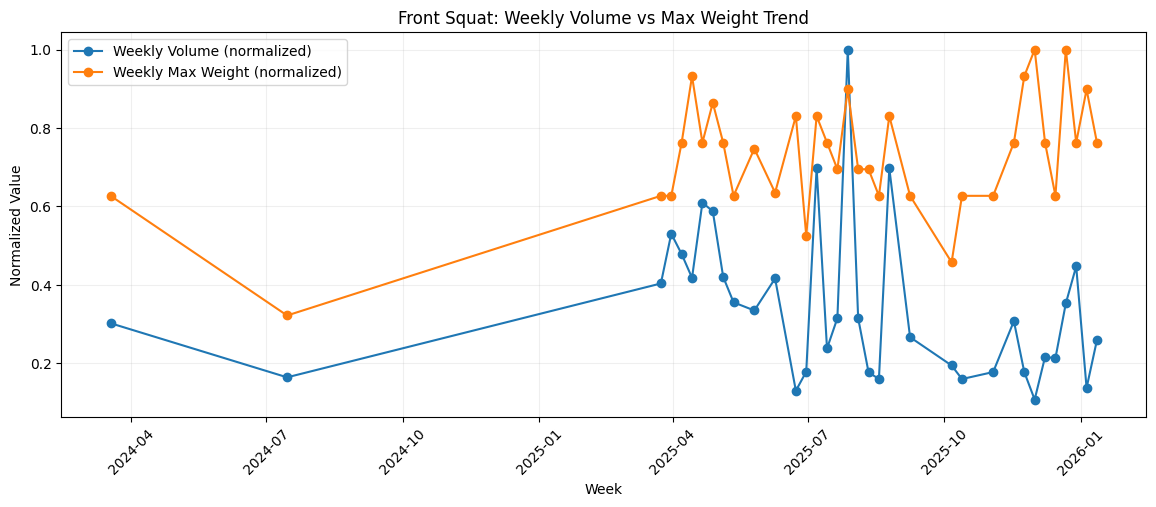

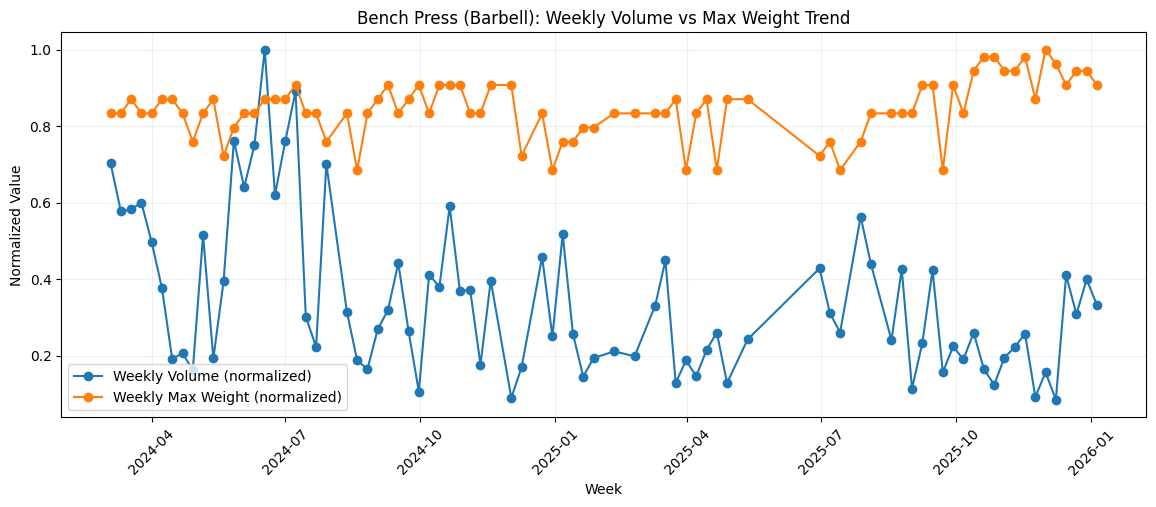

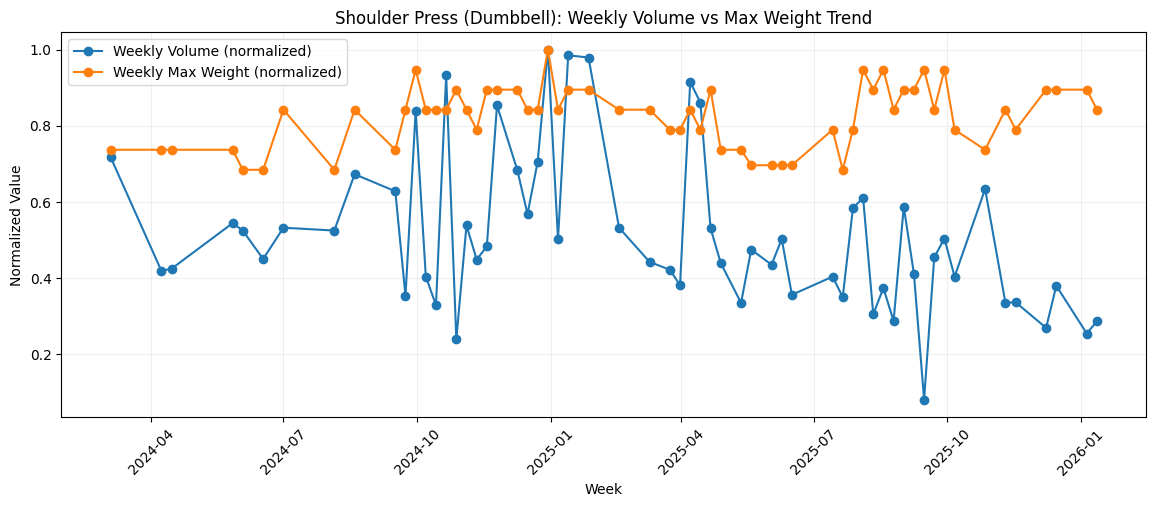

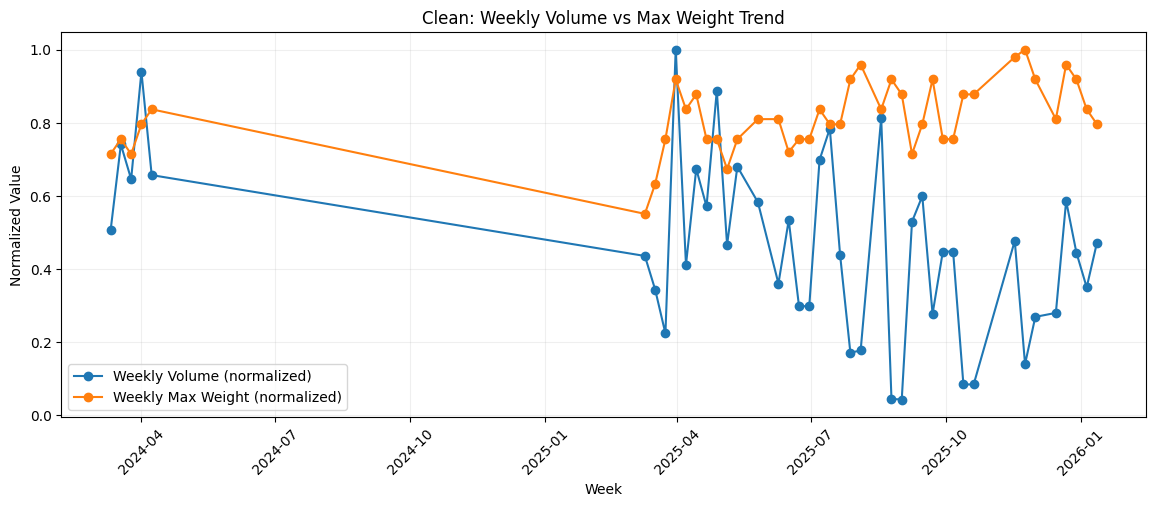

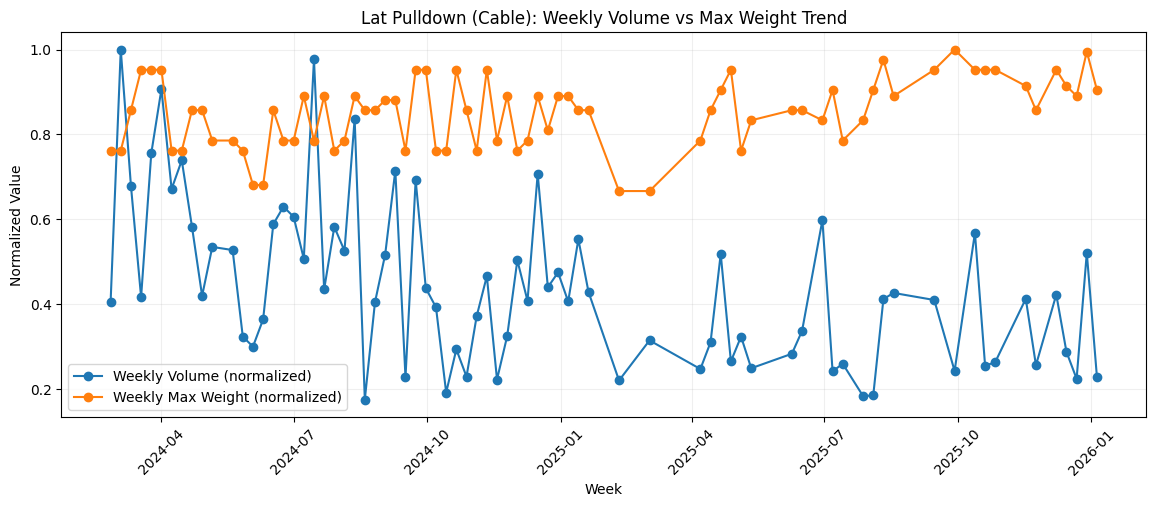

In [39]:
# plot the weekly volume and max weight over time for each exercise
for ex in exercises:
    d = weekly[weekly["exercise_title"] == ex].sort_values("week")
    if len(d) < 4:
        continue

    plt.figure(figsize=(14,5))
    
    # normalize (so they fit on same plot nicely)
    vol = d["weekly_volume"] / d["weekly_volume"].max()
    mx  = d["weekly_max_weight"] / d["weekly_max_weight"].max()

    plt.plot(d["week"], vol, marker="o", label="Weekly Volume (normalized)")
    plt.plot(d["week"], mx, marker="o", label="Weekly Max Weight (normalized)")

    plt.title(f"{ex}: Weekly Volume vs Max Weight Trend")
    plt.xlabel("Week")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.xticks(rotation=45)
    plt.show()

Each plot compares weekly volume and weekly max weight trends for one exercise. Both lines are normalized (0–1) so they can be shown on the same graph, making it easy to see whether volume changes are associated with strength changes over time.

I calculate the correlation between weekly volume and weekly max weight for each exercise. This quantifies whether increased volume tends to coincide with improved strength expression in the same weeks. Small correlations suggest the relationship is weak and may depend more on programming structure, fatigue, and recovery.

In [40]:

# weekly correlation per exercise
weekly_corr = (
    weekly.groupby("exercise_title")
    .apply(lambda d: pd.Series({
        "weeks": len(d),
        "corr_volume_vs_max_weight": d["weekly_volume"].corr(d["weekly_max_weight"])
    }))
    .reset_index()
    .sort_values("corr_volume_vs_max_weight", ascending=False)
)

weekly_corr


/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_56729/1838154507.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,exercise_title,weeks,corr_volume_vs_max_weight
2,Front Squat,35.0,0.291518
4,Shoulder Press (Dumbbell),60.0,0.162468
3,Lat Pulldown (Cable),76.0,0.027822
0,Bench Press (Barbell),82.0,-0.048815
1,Clean,43.0,-0.244687


These results show the weekly correlation between total training volume and the weekly max weight for each exercise. Front Squat (0.29) and Shoulder Press (0.16) have a small positive relationship, meaning weeks with higher volume tend to slightly align with higher max weights. Lat Pulldown (~0.03) and Bench Press (~-0.05) show almost no relationship, suggesting volume changes don’t strongly connect to max weight changes week-to-week. Clean (-0.24) shows a moderate negative relationship, meaning higher-volume weeks tend to coincide with lower max weights.

In [41]:
# lagging correlation analysis to see if volume in previous weeks affects max weight in current week
lag_results = []

for ex in exercises:
    d = weekly[weekly["exercise_title"] == ex].sort_values("week").copy()
    
    # shift max weight back so volume at week t compares to max weight at week t+1
    d["next_week_max"] = d["weekly_max_weight"].shift(-1)
    
    corr = d["weekly_volume"].corr(d["next_week_max"])
    
    lag_results.append({
        "exercise_title": ex,
        "weeks": len(d),
        "corr_volume_vs_next_week_max": corr
    })

lag_corr = pd.DataFrame(lag_results).sort_values("corr_volume_vs_next_week_max", ascending=False)
lag_corr

,exercise_title,weeks,corr_volume_vs_next_week_max
3,Shoulder Press (Dumbbell),60,0.098486
1,Front Squat,35,0.067418
2,Bench Press (Barbell),82,-0.026905
5,Lat Pulldown (Cable),76,-0.057049
4,Clean,43,-0.273397
0,Squat,0,NaN


These values show the correlation between weekly training volume for an exercise and the max weight you lift the following week (a lag test to see if volume leads to strength gains later). Shoulder Press (0.10) and Front Squat (0.07) have a very small positive relationship, suggesting higher volume weeks may slightly relate to higher max weight the next week, but the effect is weak. Bench Press (-0.03) and Lat Pulldown (-0.06) show almost no relationship, meaning volume doesn’t strongly predict next week’s max weight. Clean (-0.27) shows a moderate negative relationship, meaning higher-volume clean weeks tend to be followed by lower max weight the next week, which likely reflects fatigue or technique/volume emphasis interfering with heavier attempts. Certain exercsies like the clean are very techincal and don't make sense doing high volume sets. 

Next I want to predict my expected weights if I contiune doing low volume training. This prediciton may not be accurate due to numerous external factors such as nutrution, stress, sleep, injury, etc. I filter to low volume sessions, compute weekly max weights, then fit a linear regression model to estimate future max weights. I wanted a simple baseline forecast of future performance assuming low volume training continues. Linear progression is unrealistic long-term, so this model is more of a trend projection than a true performance predictor.

In [47]:
from sklearn.linear_model import LinearRegression

# filter by low volume 
low = low_volume_data.copy()
low["day"] = pd.to_datetime(low["day"])
low["week"] = low["day"].dt.to_period("W").apply(lambda r: r.start_time)

exercises = ["Front Squat", "Bench Press (Barbell)", "Clean", "Shoulder Press (Dumbbell)", "Lat Pulldown (Cable)"]

weekly_low = (
    low[low["exercise_title"].isin(exercises)]
    .groupby(["week", "exercise_title"])["weight_lbs"]
    .max()
    .reset_index()
)

predictions = []

# linear regression to predict next 8 weeks of max weight for each exercise
# loop through each exercise and fit a linear regression model
for ex in exercises:
    d = weekly_low[weekly_low["exercise_title"] == ex].sort_values("week")
    if len(d) < 6:
        continue

    # convert week to numbers (weeks since start)
    X = np.arange(len(d)).reshape(-1, 1)
    y = d["weight_lbs"].values
 
    model = LinearRegression() # create model
    model.fit(X, y) # fit model -> find slope + intercept

    # predict next 8 weeks
    future_X = np.arange(len(d), len(d) + 8).reshape(-1, 1)
    future_y = model.predict(future_X)

    # create future week dates 
    future_weeks = pd.date_range(d["week"].iloc[-1], periods=9, freq="W")[1:]

    # store predictions
    for wk, pred in zip(future_weeks, future_y):
        predictions.append([ex, wk.date(), pred])

# create a data frame of predictions and display them
pred_df = pd.DataFrame(predictions, columns=["exercise", "week", "predicted_max_weight"])
pred_df

,exercise,week,predicted_max_weight
0,Front Squat,2026-01-11,269.444444
1,Front Squat,2026-01-18,277.444444
2,Front Squat,2026-01-25,285.444444
3,Front Squat,2026-02-01,293.444444
4,Front Squat,2026-02-08,301.444444
5,Front Squat,2026-02-15,309.444444
6,Front Squat,2026-02-22,317.444444
7,Front Squat,2026-03-01,325.444444
8,Bench Press (Barbell),2026-01-04,260.000000
9,Bench Press (Barbell),2026-01-11,262.454545


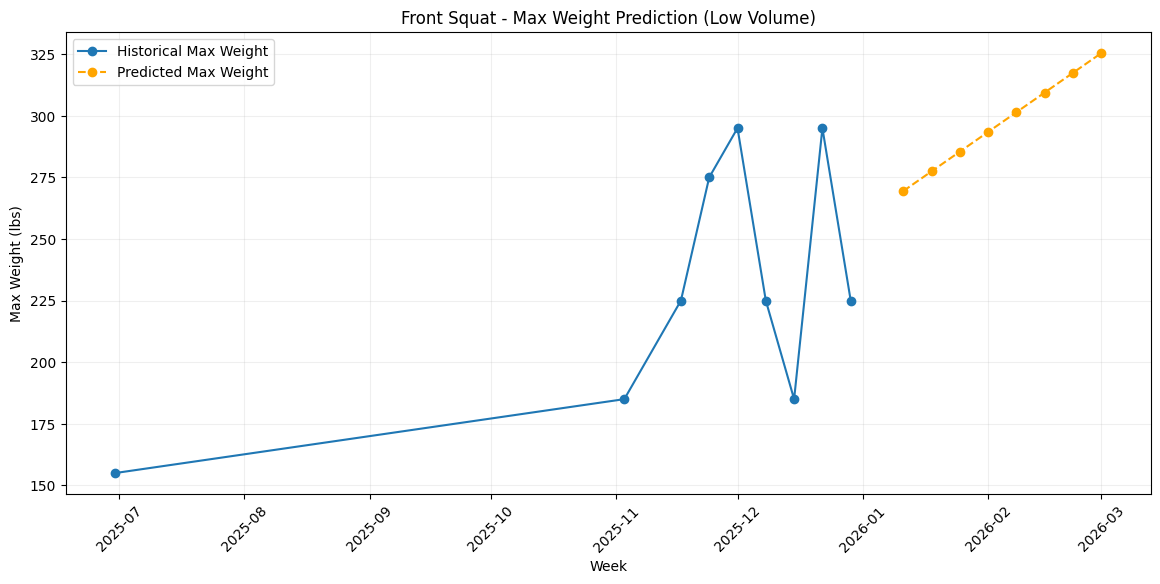

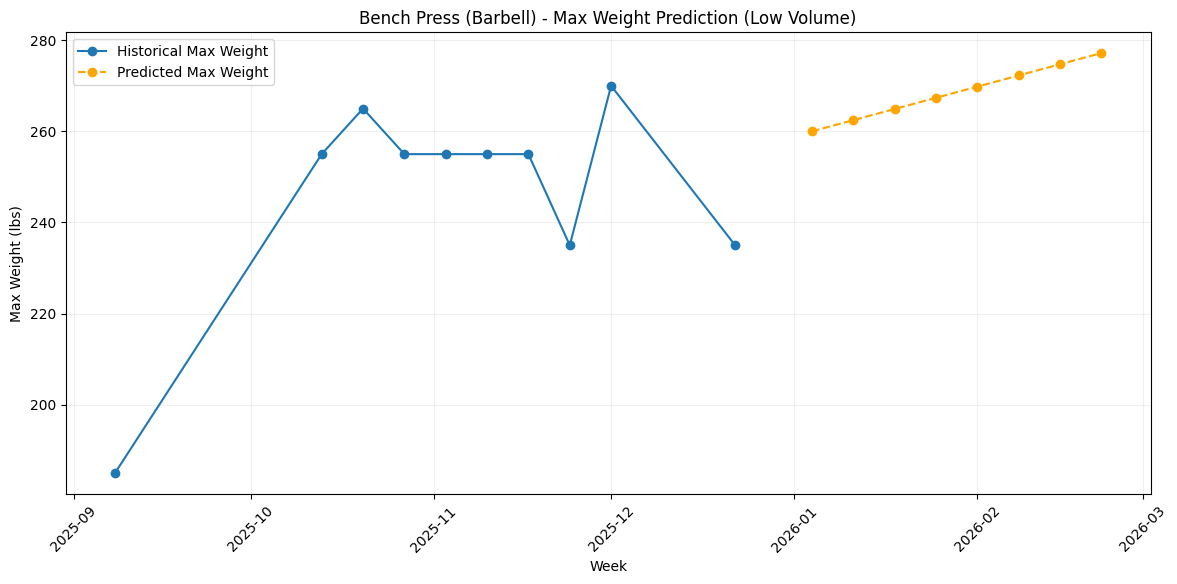

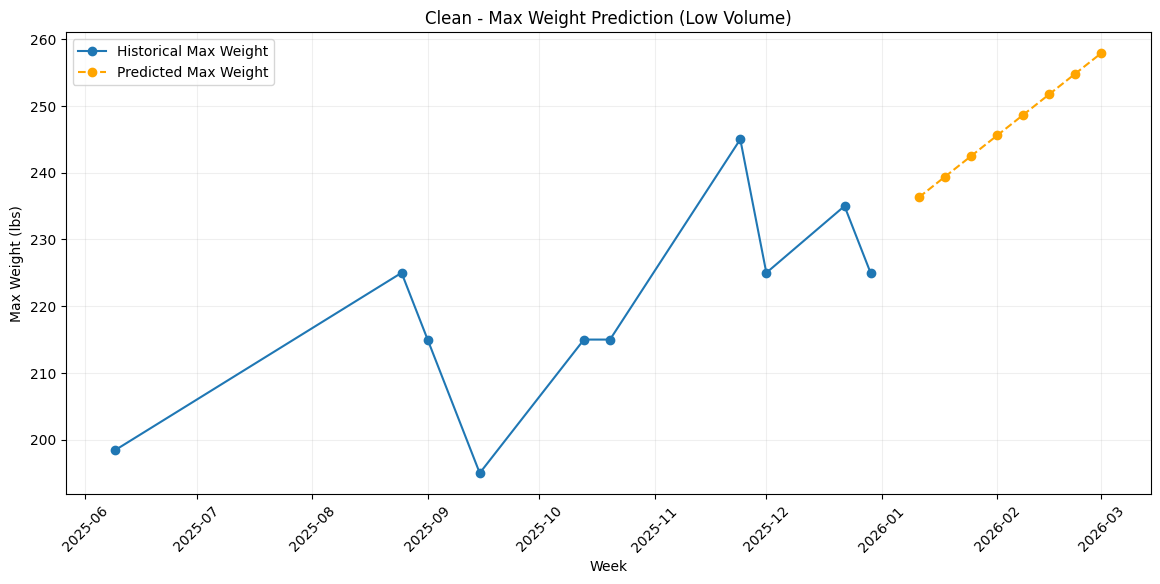

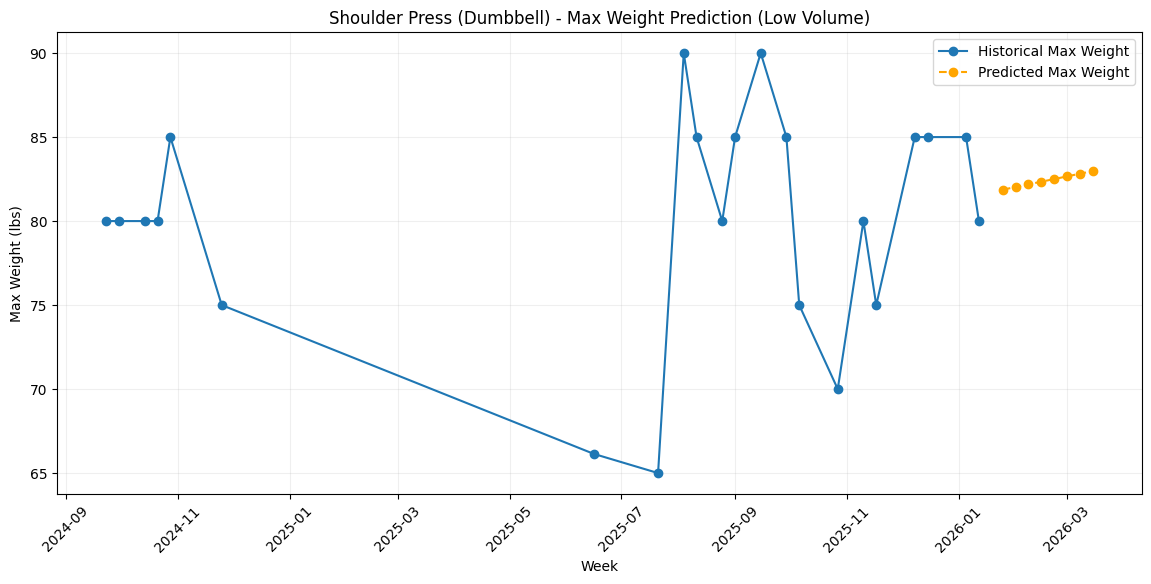

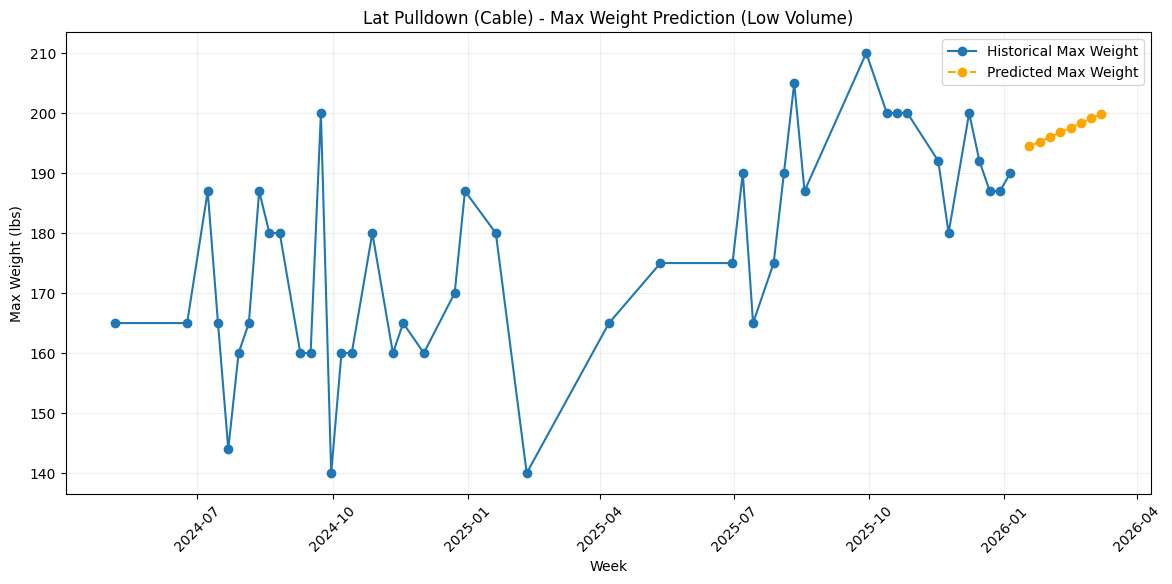

In [20]:
# visualize predictions for each exercise

# plot the historical max weight and predicted max weight for each exercise
for ex in exercises:
    d = weekly_low[weekly_low["exercise_title"] == ex].sort_values("week")
    pred_d = pred_df[pred_df["exercise"] == ex]

    # only plot if we have enough historical data
    if len(d) < 6:
        continue
    
    plt.figure(figsize=(14, 6))

    # plot historical data
    plt.plot(d["week"], d["weight_lbs"], marker="o", label="Historical Max Weight")

    # plot predictions
    plt.plot(pred_d["week"], pred_d["predicted_max_weight"], marker="o", linestyle="--", color="orange", label="Predicted Max Weight")

    # add labels and title
    plt.title(f"{ex} - Max Weight Prediction (Low Volume)")
    plt.xlabel("Week")
    plt.ylabel("Max Weight (lbs)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.xticks(rotation=45)

    plt.show()

These graphs show a prediction of the weekly max weights only doing low volume. This prediction isn't the most accurate because progress isn't linear, and it does not account for external factors previously mentioned. 

# Next is a 1 rep max using a lag feature machine learning model to predict future 1 rep maxes. 

In [44]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# prepare data for e1RM calculation and modeling
df = table.copy()
df["day"] = pd.to_datetime(df["day"])
df["week"] = df["day"].dt.to_period("W").apply(lambda r: r.start_time)

# --- e1RM formula (Epley) ---
# e1RM = w * (1 + reps/30)
# clamp reps to avoid absurd values (optional safety)
df["reps_clipped"] = df["reps"].clip(lower=1, upper=12)
df["e1rm"] = df["weight_lbs"] * (1 + df["reps_clipped"] / 30)

# weekly summary per exercise 
weekly = (
    df.groupby(["week", "exercise_title"])
      .agg(
          weekly_e1rm=("e1rm", "max"),     # take best estimate strength that week
          weekly_max_weight=("weight_lbs", "max"),
          avg_reps=("reps_clipped", "mean"),
          total_sets=("set_index", "count") if "set_index" in df.columns else ("reps_clipped", "size"),
          total_reps=("reps_clipped", "sum"),
          total_volume=("weight_lbs", lambda x: np.sum(x.values * df.loc[x.index, "reps_clipped"].values))
      )
      .reset_index()
      .sort_values(["exercise_title", "week"])
)

# create lagged features, lag features help capture trends over time by including past values as predictors
# here I create lagged features for e1RM and total volume
g = weekly.groupby("exercise_title", group_keys=False)

weekly["e1rm_lag1"] = g["weekly_e1rm"].shift(1)
weekly["e1rm_lag2"] = g["weekly_e1rm"].shift(2)
weekly["e1rm_roll3"] = g["weekly_e1rm"].rolling(3).mean().reset_index(level=0, drop=True)

weekly["vol_lag1"] = g["total_volume"].shift(1)
weekly["vol_roll3"] = g["total_volume"].rolling(3).mean().reset_index(level=0, drop=True)

weekly["sets_lag1"] = g["total_sets"].shift(1)
weekly["reps_lag1"] = g["total_reps"].shift(1)

# target variable - predict next week's e1RM
weekly["next_week_e1rm"] = g["weekly_e1rm"].shift(-1)

# prepare data for modeling by dropping rows with missing values in key columns
model_data = weekly.dropna(subset=[
    "e1rm_lag1", "e1rm_lag2", "e1rm_roll3", 
    "vol_lag1", "vol_roll3",
    "sets_lag1", "reps_lag1",
    "next_week_e1rm"
]).copy()

# function to split data into training and testing sets based on time 
def split_train_test(ex_df, test_frac=0.2):
    ex_df = ex_df.sort_values("week")
    n = len(ex_df)
    cut = int(np.floor(n * (1 - test_frac)))
    return ex_df.iloc[:cut], ex_df.iloc[cut:]

# store training and testing parts for all exercises
train_parts = []
test_parts = []

# loop through each exercise and split data
for ex, ex_df in model_data.groupby("exercise_title"):
    if len(ex_df) < 10:  # not enough data
        continue
    tr, te = split_train_test(ex_df, test_frac=0.2)
    train_parts.append(tr)
    test_parts.append(te)

# combine all training and testing parts
train = pd.concat(train_parts) if len(train_parts) else pd.DataFrame()
test  = pd.concat(test_parts) if len(test_parts) else pd.DataFrame()

# define features and target variable
features = ["e1rm_lag1","e1rm_lag2","e1rm_roll3","vol_lag1","vol_roll3","sets_lag1","reps_lag1"]

# split into X and y
X_train, y_train = train[features], train["next_week_e1rm"]
X_test,  y_test  = test[features],  test["next_week_e1rm"]

# train a Random Forest Regressor model 
# random forest is good for capturing non-linear relationships and interactions between features so it's suitable for this type of data
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=2
)
model.fit(X_train, y_train)

pred_test = model.predict(X_test)

print("Test R²:", round(r2_score(y_test, pred_test), 4)) # R-squared metric -> goodness of fit
print("Test MAE (e1RM lbs):", round(mean_absolute_error(y_test, pred_test), 2)) # Mean Absolute Error -> average prediction error in lbs

Test R²: 0.9193
Test MAE (e1RM lbs): 19.31


# I want to use the data to predict my future one rep maxes if I continue doing low volume training
# Forecasting e1RM (Estimated 1-Rep Max) – What This Cell Is Doing

This cell generates **future predicted e1RM values** for a given exercise using the `forecast_e1rm()` function.  
It uses the existing weekly training history (stored in the `weekly` dataframe) and a trained machine learning model (`model`) to forecast the next `weeks_ahead` weeks.
I compute estimated 1-rep max (e1RM) per set using the Epley formula and build a weekly dataset for predictive modeling. e1RM is a stronger metric than raw max weight because it converts rep work into a comparable strength estimate. e1RM can still be noisy (especially on high-rep sets), but weekly averages smooth this significantly.

---

## What the `forecast_e1rm()` function does

The function forecasts **one exercise at a time** (ex: Squat, Bench Press, etc.) and returns a dataframe of future predictions:

| week | predicted_e1rm |
|------|----------------|
| next week | 315.2 |
| +2 weeks | 317.6 |
| ... | ... |

It does this by repeating a 1-week-ahead prediction loop `weeks_ahead` times.

In [45]:
# This function is doing multi-week forecasting of your exercise e1RM (estimated 1-rep max) using your trained ML model one week at a time
# each predicted week becomes part of the history used to predict the next week.
def forecast_e1rm(weekly, exercise_name, weeks_ahead=8):
    ex_hist = weekly[weekly["exercise_title"] == exercise_name].sort_values("week").copy()

    # need at least 6 weeks
    if len(ex_hist) < 6:
        return None
    
    future_rows = []

    # predict 
    for _ in range(weeks_ahead):
        last = ex_hist.iloc[-1]
        prev1 = ex_hist.iloc[-2]

        e1rm_lag1 = last["weekly_e1rm"]
        e1rm_lag2 = prev1["weekly_e1rm"]
        e1rm_roll3 = ex_hist["weekly_e1rm"].iloc[-3:].mean()

        vol_lag1 = last["total_volume"]
        vol_roll3 = ex_hist["total_volume"].iloc[-3:].mean()

        sets_lag1 = last["total_sets"]
        reps_lag1 = last["total_reps"]

        X_next = pd.DataFrame([{
            "e1rm_lag1": e1rm_lag1,
            "e1rm_lag2": e1rm_lag2,
            "e1rm_roll3": e1rm_roll3,
            "vol_lag1": vol_lag1,
            "vol_roll3": vol_roll3,
            "sets_lag1": sets_lag1,
            "reps_lag1": reps_lag1
        }])

        pred_next_e1rm = model.predict(X_next)[0]
        next_week = last["week"] + pd.Timedelta(days=7)

        # roll forward with assumptions
        new_row = last.copy()
        new_row["week"] = next_week
        new_row["weekly_e1rm"] = pred_next_e1rm
        new_row["total_volume"] = vol_roll3
        new_row["total_sets"] = sets_lag1
        new_row["total_reps"] = reps_lag1

        ex_hist = pd.concat([ex_hist, pd.DataFrame([new_row])], ignore_index=True)
        future_rows.append({"week": next_week, "predicted_e1rm": pred_next_e1rm})

    return pd.DataFrame(future_rows)

# convert e1RM back to weight for a given number of reps
def e1rm_to_weight(e1rm, reps):
    return e1rm / (1 + reps/30)

# forecast weights for different rep ranges based on predicted e1RM
def forecast_weights(weekly, exercise_name, reps_list=[1,3,5], weeks_ahead=8):
    f = forecast_e1rm(weekly, exercise_name, weeks_ahead=weeks_ahead)
    if f is None or f.empty:
        return None

    for r in reps_list:
        f[f"pred_weight_{r}rep"] = f["predicted_e1rm"].apply(lambda x: e1rm_to_weight(x, r))

    return f

# forecast weights for specific exercises
exercises_to_forecast = [
    "Squat",
    "Front Squat",
    "Bench Press (Barbell)",
    "Shoulder Press (Dumbbell)",
    "Clean",
    "Lat Pulldown (Cable)"
]

all_forecasts = []

# loop through each exercise and generate forecasts
for ex in exercises_to_forecast:
    f = forecast_weights(weekly, ex, reps_list=[1,3,5], weeks_ahead=8)  # weekly MUST exist above
    if f is None or f.empty:
        continue
    f["exercise"] = ex
    all_forecasts.append(f)

# display forecasts
for df in all_forecasts:
    print(df["exercise"].iloc[0])
    display(df)


Front Squat


,week,predicted_e1rm,pred_weight_1rep,pred_weight_3rep,pred_weight_5rep,exercise
0,2026-01-19,249.397399,241.352322,226.724908,213.769199,Front Squat
1,2026-01-26,250.861058,242.768766,228.055507,215.023764,Front Squat
2,2026-02-02,244.485707,236.599072,222.259734,209.559178,Front Squat
3,2026-02-09,244.011831,236.140482,221.828938,209.152998,Front Squat
4,2026-02-16,244.519487,236.631761,222.290443,209.588132,Front Squat
5,2026-02-23,243.302111,235.453655,221.183737,208.544666,Front Squat
6,2026-03-02,240.554401,232.794582,218.685819,206.189487,Front Squat
7,2026-03-09,241.047425,233.271702,219.134023,206.612079,Front Squat


Bench Press (Barbell)


,week,predicted_e1rm,pred_weight_1rep,pred_weight_3rep,pred_weight_5rep,exercise
0,2026-01-12,260.271317,251.875468,236.610288,223.089700,Bench Press (Barbell)
1,2026-01-19,251.036043,242.938106,228.214584,215.173751,Bench Press (Barbell)
2,2026-01-26,250.504872,242.424069,227.731701,214.718461,Bench Press (Barbell)
3,2026-02-02,247.707368,239.716807,225.188516,212.320601,Bench Press (Barbell)
4,2026-02-09,247.922924,239.925411,225.384477,212.505364,Bench Press (Barbell)
5,2026-02-16,246.004129,238.068512,223.640117,210.860682,Bench Press (Barbell)
6,2026-02-23,242.053974,234.245782,220.049068,207.474835,Bench Press (Barbell)
7,2026-03-02,241.632680,233.838077,219.666072,207.113725,Bench Press (Barbell)


Shoulder Press (Dumbbell)


,week,predicted_e1rm,pred_weight_1rep,pred_weight_3rep,pred_weight_5rep,exercise
0,2026-01-19,99.655046,96.440367,90.595496,85.418611,Shoulder Press (Dumbbell)
1,2026-01-26,100.129897,96.899900,91.027179,85.825626,Shoulder Press (Dumbbell)
2,2026-02-02,100.252935,97.018969,91.139032,85.931087,Shoulder Press (Dumbbell)
3,2026-02-09,99.314789,96.111086,90.286172,85.126962,Shoulder Press (Dumbbell)
4,2026-02-16,99.826603,96.606390,90.751457,85.565660,Shoulder Press (Dumbbell)
5,2026-02-23,99.439519,96.231792,90.399562,85.233873,Shoulder Press (Dumbbell)
6,2026-03-02,100.369206,97.131489,91.244733,86.030748,Shoulder Press (Dumbbell)
7,2026-03-09,99.300502,96.097260,90.273183,85.114716,Shoulder Press (Dumbbell)


Clean


,week,predicted_e1rm,pred_weight_1rep,pred_weight_3rep,pred_weight_5rep,exercise
0,2026-01-19,228.141564,220.782159,207.401422,195.549912,Clean
1,2026-01-26,230.606681,223.167756,209.642437,197.662870,Clean
2,2026-02-02,218.278458,211.237218,198.434962,187.095821,Clean
3,2026-02-09,219.128146,212.059496,199.207405,187.824125,Clean
4,2026-02-16,221.440692,214.297444,201.309720,189.806308,Clean
5,2026-02-23,226.861155,219.543053,206.237413,194.452418,Clean
6,2026-03-02,225.395744,218.124913,204.905221,193.196352,Clean
7,2026-03-09,220.582820,213.467245,200.529836,189.070989,Clean


Lat Pulldown (Cable)


,week,predicted_e1rm,pred_weight_1rep,pred_weight_3rep,pred_weight_5rep,exercise
0,2026-01-12,219.581008,212.497749,199.619098,188.212292,Lat Pulldown (Cable)
1,2026-01-19,221.980698,214.820030,201.800635,190.269170,Lat Pulldown (Cable)
2,2026-01-26,218.161005,211.123553,198.328186,186.995147,Lat Pulldown (Cable)
3,2026-02-02,227.387113,220.052045,206.715558,194.903240,Lat Pulldown (Cable)
4,2026-02-09,224.399005,217.160328,203.999096,192.342004,Lat Pulldown (Cable)
5,2026-02-16,218.493799,211.445611,198.630726,187.280399,Lat Pulldown (Cable)
6,2026-02-23,219.943732,212.848773,199.948847,188.523199,Lat Pulldown (Cable)
7,2026-03-02,225.317437,218.049133,204.834034,193.129232,Lat Pulldown (Cable)


I plot forecasted weekly weights for different rep targets (1/3/5 reps) for each main lift. This provides a realistic training-facing forecast: not just 1RM, but predicted working weights for common rep ranges. Predictions should be treated as ranges, not exact numbers. Real performance depends on fatigue, nutrition, stress, and consistency. This gives me a general idea of where my weights should be at in different rep ranges. 

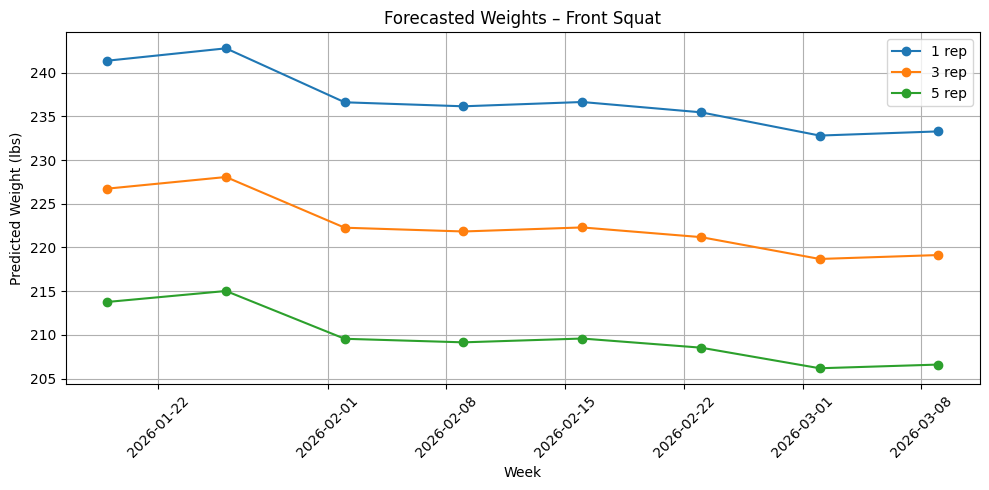

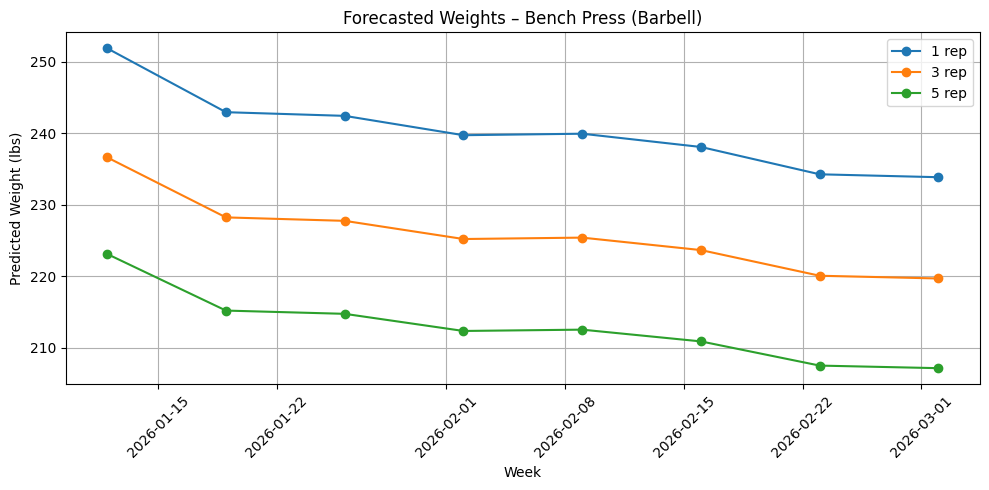

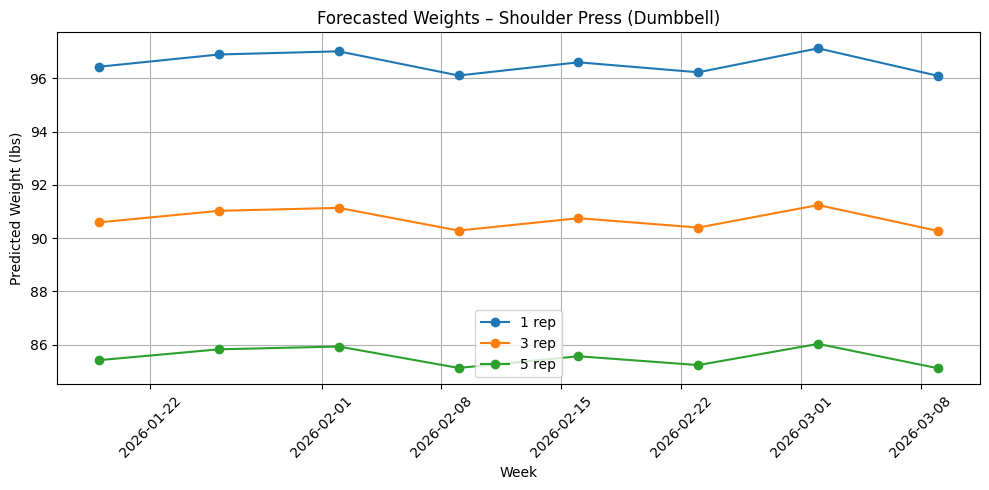

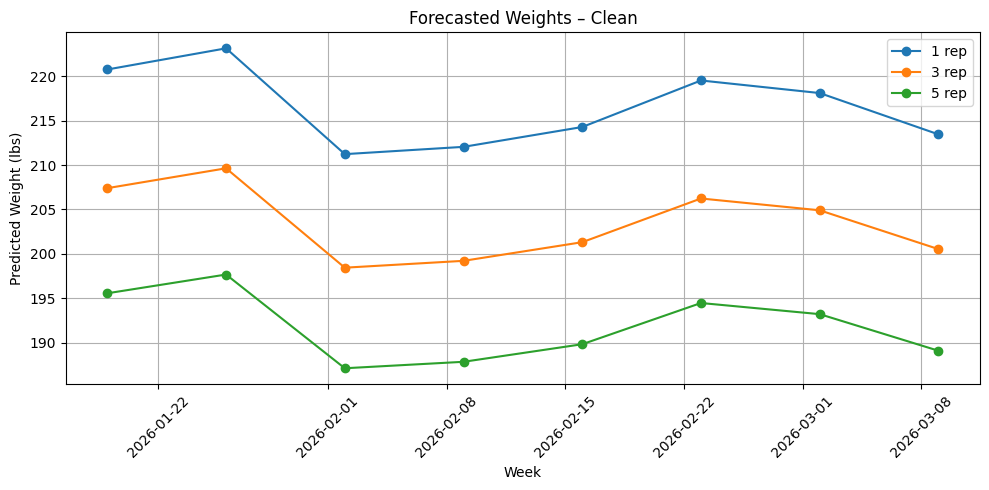

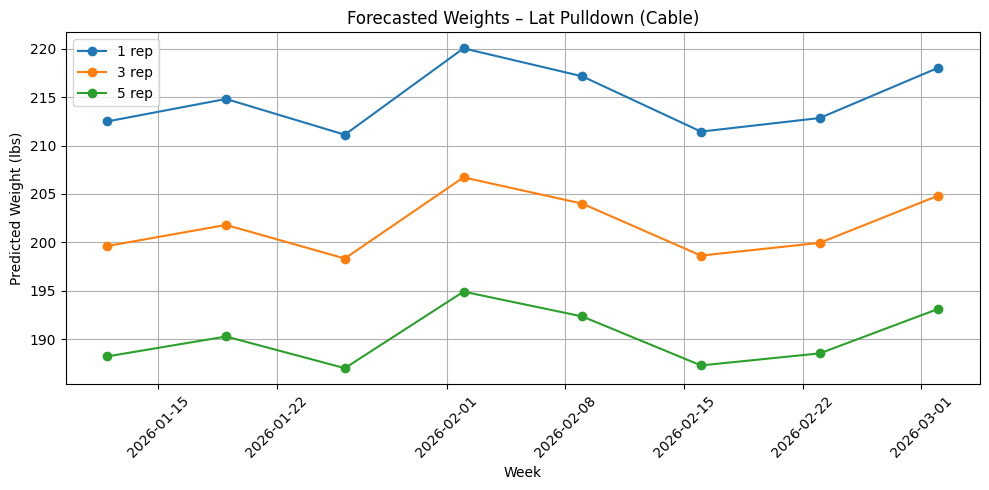

In [23]:
for df in all_forecasts:
    ex = df["exercise"].iloc[0]

    plt.figure(figsize=(10,5))
    plt.plot(df["week"], df["pred_weight_1rep"], marker="o", label="1 rep")
    plt.plot(df["week"], df["pred_weight_3rep"], marker="o", label="3 rep")
    plt.plot(df["week"], df["pred_weight_5rep"], marker="o", label="5 rep")

    plt.title(f"Forecasted Weights – {ex}")
    plt.xlabel("Week")
    plt.ylabel("Predicted Weight (lbs)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()